In [548]:
import time
from typing import List, Dict
import scipy.integrate
from scipy.integrate import solve_ivp
import autograd.numpy as np
import torch
from torch import Tensor
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.datasets
import torch.nn as nn
import torch.optim as optim
import autograd.numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [549]:
import torch
import numpy as np

def ABM(model, x0, sf, s0):
    # Constants
    a = 600000  # m
    mu = 3.9860064E+14  # m^3/s^2

    # Orbit period calculated through Kepler's Third Law
    T = np.sqrt(a**3 * (4 * np.pi**2 / mu))
    ########## FIXXXX
    ds = T/250
    #print("Step size (ds):", ds)

    # Calculate number of steps based on the given time interval and step size
    s = np.arange(s0, sf, ds)
    print(len(s))
    ns = len(s)  # Get the exact number of elements in s
    # Ensure x0 is a torch tensor with the correct shape
    if not isinstance(x0, torch.Tensor):
        x0 = torch.tensor(x0, dtype=torch.float32)
    if x0.dim() == 1:
        x0 = x0.unsqueeze(0)  # Ensures x0 is [1, 6] if it's provided as [6]

    # Initialize the tensor to store the simulation results
    x = torch.zeros((ns, x0.size(1)), dtype=x0.dtype, device=x0.device,requires_grad=True)
    # print("x0",x0)
    # Set initial state
    x[0, :] = x0.squeeze()  # Make sure x0 is squeezed to [6]

    f = model.func
    theta = model.theta
    # First initialize with an RK4 step for stability in starting the integration
    for k in range(3):
        if k + 1 < ns:
            k1 = ds * f(s[k], x[k, :],theta)
            k2 = ds * f(s[k] + ds/2, x[k, :] + k1/2,theta)
            k3 = ds * f(s[k] + ds/2, x[k, :] + k2/2,theta)
            k4 = ds * f(s[k] + ds, x[k, :] + k3,theta)
            dx = (k1 + 2*k2 + 2*k3 + k4) / 6
            x[k + 1, :] = x[k, :] + dx

    # ABM integration
    for k in range(3, ns - 1):
        if k - 3 >= 0:  # Make sure indices don't go out of bounds
            f_m3 = f(s[k-3], x[k-3, :],theta)
            f_m2 = f(s[k-2], x[k-2, :],theta)
            f_m1 = f(s[k-1], x[k-1, :],theta)
            f_0 = f(s[k], x[k, :],theta)

            # Predictor
            dx = (ds/24) * (55 * f_0 - 59 * f_m1 + 37 * f_m2 - 9 * f_m3)
            x[k + 1, :] = x[k, :] + dx

            # Evaluate at the predicted next step (ensure not at the last step)
            if k + 1 < ns - 1:
                f_p1 = f(s[k + 1], x[k + 1, :],theta)
                # Corrector
                dx = (ds/24) * (9 * f_p1 + 19 * f_0 - 5 * f_m1 + f_m2)
                x[k + 1, :] = x[k, :] + dx

    # Return the results

    return x

In [550]:
#def augmented_dynamics(t, aug_start, theta,a_t,aug =1):
#aug_state_t0 = ABM_aug(augmented_dynamics,aug_state0, time[i+1],time[i],theta,grad_zt,1)
import math
def ABM_aug(f, x0, sf, s0, theta):

  k = 0.001
  # Number of steps
  dt = 168
  N =5
  # Initialize y
  y = torch.zeros((N+1, 18), dtype=x0.dtype, device=x0.device,requires_grad=True)
  y[0,:] = x0.squeeze(0)

  # Reverse time integration using modified Euler's method
  for i in range(1, N+1):
    y[i,:] = f(s0,y[i-1],theta) + dt * k * f(s0,y[i-1],theta)
  return y

In [551]:
class X_ddot_class(nn.Module):
    def __init__(self):
        super(X_ddot_class, self).__init__()

    def forward(self, t, X, theta):
        mu = .5
        x = X[:3]
        v = X[3:]

        r = torch.norm(x, dim=0, keepdim=True)
        v_dot = -mu * x / r.pow(3)
        X_dot_dot = torch.cat((v, v_dot), dim=0)

        X_dot_dot = X_dot_dot * theta

        return X_dot_dot

    def forward_with_grad(self, t, z, theta ,a):
        """Compute f and a df/dz, a df/dp, a df/dt"""

        out = self.forward(t, z, theta)

        dfdt, dfdz, dfdtheta = torch.autograd.grad(outputs=out, inputs=[t, z, theta], grad_outputs=torch.ones_like(out),allow_unused=True, retain_graph=True)
        # grad method automatically sums gradients for batch items, we have to expand them back

        adfdz = torch.zeros(6) if dfdz is None else -a * dfdz
        adfdp = torch.zeros(6) if dfdtheta is None else -a * dfdtheta
        adfdt = torch.zeros(6) if dfdt is None else -a * dfdt


        #this line contains a lot of bullshit
        return torch.cat([out, adfdz, adfdp])


In [552]:
# we have to create a custom forward and backwards pass
# use torch.autograd.Function for this purpose
class ODEForwardBackward(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, theta ,t0,t1,time,model):
        # Ensure initial state and time vector are properly formatted
        # print("z0",z0.requires_grad)
        z0 = z0.squeeze()# Correct shape if necessary
        # print("z0",z0.requires_grad)
        # print("z0",z0.shape)
        z = torch.zeros((50,z0.size(0)), dtype=z0.dtype, device=z0.device)
        # Simulate the dynamics over the given time frame
        z[0] = z0
        for i in range(50-1):
          ztest = ABM(model, z0, time[i+1], time[i])[-1]
          z[i+1] = ztest
        # print("forward z",z[-1])
        # Save for backward pass

        # print("HEY")
        # print(get_grads(t1,z[-1],theta))

        ctx.save_for_backward(z, time[0],time[-1], theta)
        ctx.model = model

        # Return the final state
        return z


    @staticmethod
    # pytorch AUTOMATICALLY gives us the loss gradient over the entire function.
    # therefore, from that gradient, we must return dldz0, dldt, and dldp
    # this is outlined in the appendix
    def backward(ctx, grad_zt):
        z,t0,t1,theta = ctx.saved_tensors
        zt1 = z[-1]
        #print("BACK")
        #print("t0",t0)
        #print("t1",t1)
        model = ctx.model
        #print("num parma",len(theta))
        #print("theta",theta)

        # Reconstruct augmented state at final time
        grad_t1 = grad_zt[-1] *np.transpose(model.func(t1,zt1,theta) ) # Assuming scalar t


        aug_state0 = torch.cat([zt1, -grad_zt[-1], torch.zeros_like(theta).flatten()])
        # Reverse time ODE solve (backpropagate from t1 to t0) THIS IS WRONG
        #audited_dynamics = Augmented_dynamics(model=model)
        #print("aug_state0",aug_state0)
        # print("HEY")
        # print(get_grads(t,zt1,theta))

        #print("augmented_dynamics",augmented_dynamics

        def augmented_dynamics(t, aug_start, theta):
          z   = aug_start[:6]
          a = aug_start[6:12]

          func = X_ddot_class()

          z = z.clone().detach().requires_grad_(True)
          theta = theta.clone().detach().requires_grad_(True)
          t_tensor = torch.tensor([t], dtype=torch.float32, requires_grad=True)

          # Get function output
          with torch.set_grad_enabled(True):
            f_output = func.forward_with_grad(t_tensor, z, theta, a)
          return f_output

        aug_state_t0 = ABM_aug(augmented_dynamics,aug_state0, time[-1],time[-2],theta)[-1]

        # Extract gradients w.r.t. initial state, parameters, and initial and final times
        #print("aug_0",aug_state_t0)
        # print("HEEE",aug_state_t0.size)
        #print("aug_0",aug_state_t0[-1])
        aug_state_t0 = aug_state_t0
        #print("z0_aug",aug_state_t0[0:6]
        #aug_state_t0 = aug_state_t0[-1]

        #print("z0_aug",aug_state_t0[0:6] )
        #print("grad_z0",aug_state_t0[6:12])
        grad_z0 = aug_state_t0[6:12].unsqueeze(0)
        #print("grad_theta",aug_state_t0[12:12+len(theta)])
        grad_theta = aug_state_t0[12:12+len(theta)].unsqueeze(0)
        #print("grad_t0/grad_t1",aug_state_t0[12+len(theta):12+len(theta)+6],grad_t1)
        grad_t0 = aug_state_t0[12+len(theta):].unsqueeze(0)

        # Return gradients
        # print("grad_t0",grad_t0)
        # print("grad_t1",grad_t1)


        return grad_z0, grad_theta, None, None,None,None


In [553]:
class NeuralODE(nn.Module):
  def __init__(self,func,theta):
    super().__init__()
    self.func = func
    self.adtheta = nn.Parameter(torch.ones(6*4, requires_grad=True))
    self.theta =nn.Parameter(theta)

  def forward(self, z0,time):
    # Pass the input through the function
    return ODEForwardBackward.apply(z0, self.theta , time[0],time[-1], time, self)

In [554]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader

In [555]:
data = pd.read_csv('jan_train.csv')

# change this as needed for the number of satellites used
data = data.head(50)
data = data[data['sat_id'].isin([0, 1, 2, 3, 4, 5, 6])]

# Convert time to seconds since first day
data['epoch'] = pd.to_datetime(data['epoch'])
reference_time = pd.Timestamp('2014-01-01 00:00:00.000')
data['time'] = (data['epoch'] - reference_time).dt.total_seconds()
data.drop(columns=['epoch'], inplace=True)
data['time'] = data['time'].astype(int)

# Fill in NA cells with average
data.fillna(data.mean(), inplace=True)

# Remove outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = ((data < lower_bound) | (data > upper_bound)).any(axis=1)
data = data[~outlier_mask]

# Normalize between -1 and 1
numeric_cols = data.select_dtypes(include=[np.number]).columns.difference(['time', 'id', 'sat_id'])
scaler = MinMaxScaler(feature_range=(-1, 1))
data.loc[:, numeric_cols] = scaler.fit_transform(data[numeric_cols])

data[:10]

,id,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,time
0,0,0,-0.876008,0.517266,-0.884563,-0.524434,-0.865959,-0.508260,-0.875552,0.517827,-0.884327,-0.525323,-0.865710,-0.509099,0
1,1,0,-0.998863,0.186322,-1.000000,-0.083036,-1.000000,-0.063057,-0.998669,0.187166,-1.000000,-0.084406,-0.999968,-0.064387,2803
2,2,0,-0.999653,-0.153318,-0.993380,0.339642,-0.935000,0.358978,-0.999845,-0.152310,-0.993741,0.338081,-0.935558,0.357443,5606
3,3,0,-0.896995,-0.454700,-0.884316,0.658943,-0.740439,0.674555,-0.897588,-0.453710,-0.885053,0.657589,-0.741606,0.673219,8409
4,4,0,-0.722661,-0.692951,-0.705075,0.860733,-0.493822,0.871235,-0.723576,-0.692132,-0.706106,0.859817,-0.495382,0.870332,11212
5,5,0,-0.506596,-0.860986,-0.485711,0.965746,-0.243244,0.970864,-0.507710,-0.860421,-0.486913,0.965317,-0.244951,0.970442,14015
6,6,0,-0.271863,-0.961221,-0.249196,1.000000,-0.010601,1.000000,-0.273055,-0.960935,-0.250448,1.000000,-0.012269,1.000000,16818
7,7,0,-0.034970,-0.999930,-0.011875,0.984302,0.196660,0.979655,-0.036137,-0.999906,-0.013074,0.984634,0.195147,0.979978,19621
8,8,0,0.192420,-0.984440,0.214772,0.933101,0.377491,0.924332,0.191358,-0.984632,0.213700,0.933665,0.376197,0.924873,22424
9,9,0,0.401913,-0.921983,0.422520,0.855884,0.533162,0.843507,0.401009,-0.922336,0.421626,0.856585,0.532112,0.844170,25227


In [556]:
#get the processed data into dataloader, ready for use in the network
class SatelliteDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

features = data[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']].values
targets = data[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']].values

time = data['time'].values
time = time.reshape(-1, 1)
time = torch.tensor(time, dtype=torch.float32,requires_grad=True)
# convert to tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)

dataset = SatelliteDataset(features_tensor, targets_tensor)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


In [557]:
# model evaluation
# ODE = X_ddot_class()
# model = NeuralODE(ODE)

# loss and optimizer
Test = X_ddot_class()

criterion = nn.MSELoss()

theta = torch.ones(6)
model = NeuralODE(Test,theta)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# training


loss_list = []
y_pred_list = []
model.train()
epochs = 15
# for now, do batch size of 1, for simpler adjustments in ODE
for epoch in range(epochs):
  total_loss = 0
  traj = []
  sim = []
  for x_1 , y1 in dataloader:
      x_1 = torch.autograd.Variable(x_1, requires_grad=True)
      y_1 = torch.autograd.Variable(y1, requires_grad=True)
      traj.append(x_1)
      sim.append(y1)
  traj = torch.stack(traj,dim=0)
  sim = torch.stack(sim,dim=0)
  sim = sim.squeeze()


  y_pred = model(x_1[0],time)
  y_pred_list.append(y_pred)
  optimizer.zero_grad()
  loss = criterion(y_pred, sim)
  total_loss += loss.item()
  loss.backward(retain_graph=True)
  optimizer.step()
  average_loss = total_loss
  loss_list.append(average_loss)
  print ("Epoch:", epoch, "Average Loss:", average_loss)

model.eval()
with torch.no_grad():
  y_pred_f = model(x_1[0], time)


Epoch: 0 Average Loss: 403196.75
Epoch: 1 Average Loss: 246611.171875
Epoch: 2 Average Loss: 139487.9375
Epoch: 3 Average Loss: 46057.9609375
Epoch: 4 Average Loss: 1.2886991500854492
Epoch: 5 Average Loss: 1.3037574291229248
Epoch: 6 Average Loss: 0.9216576218605042
Epoch: 7 Average Loss: 1.0270222425460815
Epoch: 8 Average Loss: 1.1159229278564453
Epoch: 9 Average Loss: 0.8820223808288574
Epoch: 10 Average Loss: 1.214234471321106
Epoch: 11 Average Loss: 1.103653907775879
Epoch: 12 Average Loss: 0.9931591749191284
Epoch: 13 Average Loss: 0.9998440742492676
Epoch: 14 Average Loss: 0.9627940058708191


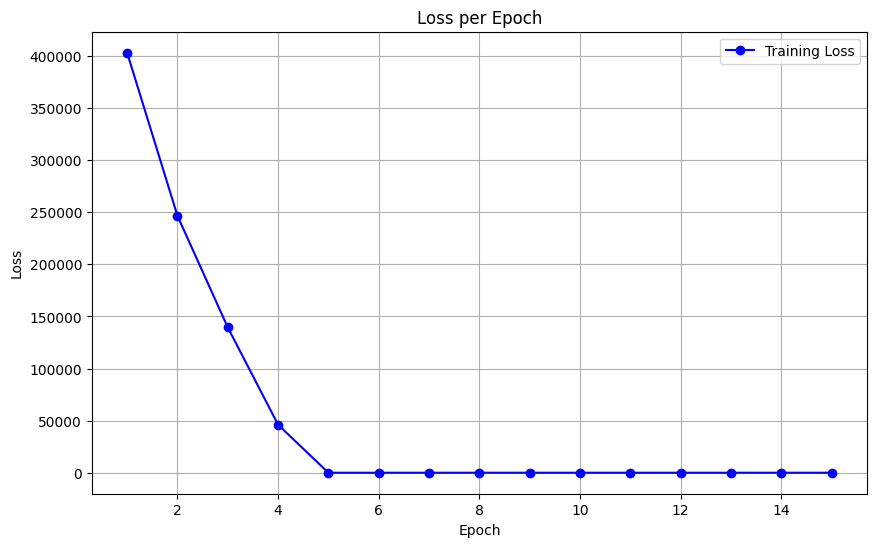

In [558]:
epochs = range(1, len(loss_list) + 1)

# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(epochs, loss_list, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epochs = range(1, len(loss_list) + 1)

# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(epochs[3:], loss_list[3:], marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

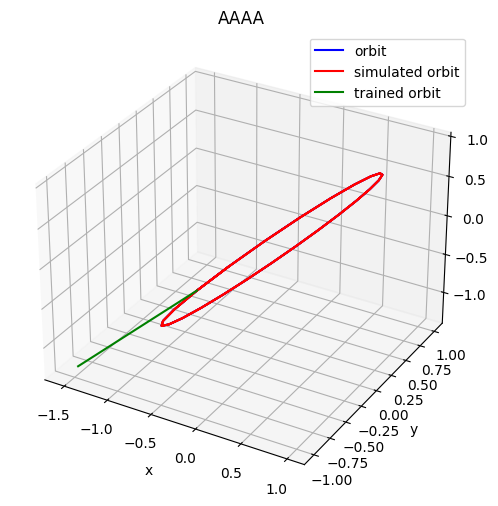

In [560]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection="3d")

traj = traj.squeeze()
y_pred= y_pred_f.squeeze()
traj = traj.detach().numpy()
sim = sim.detach().numpy()
y_pred_f = y_pred_f.detach().numpy()
x, y, z = traj[:,0], traj[:,1], traj[:, 2]
xsim, ysim, zsim = sim[:,0], sim[:,1], sim[:, 2]
x_trained, y_trained, z_trained = y_pred[:,0], y_pred[:,1], y_pred[:,2]
ax.plot3D(x, y, z, 'blue', label="orbit")
ax.plot3D(xsim, ysim, zsim, 'red', label="simulated orbit")
ax.plot3D(x_trained, y_trained, z_trained, 'green', label="trained orbit")
ax.legend()

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("AAAA")

plt.show()

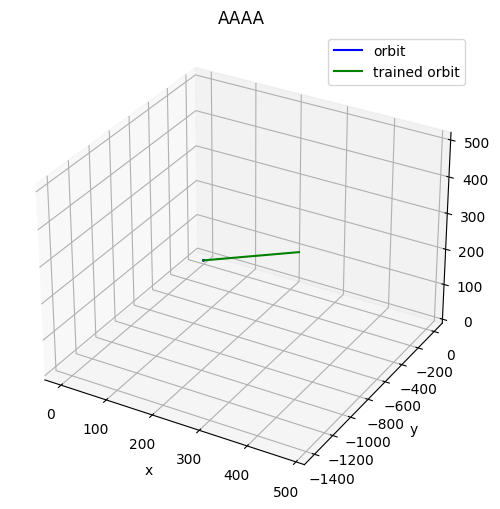

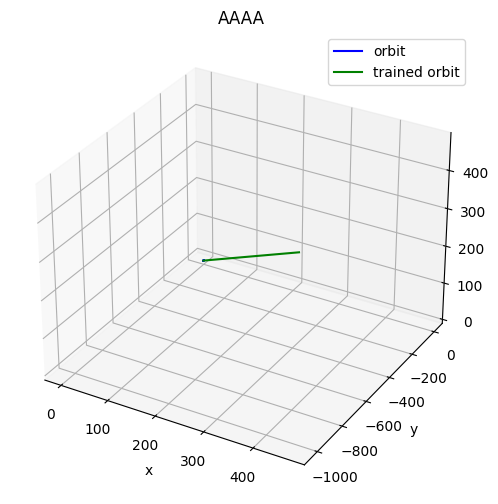

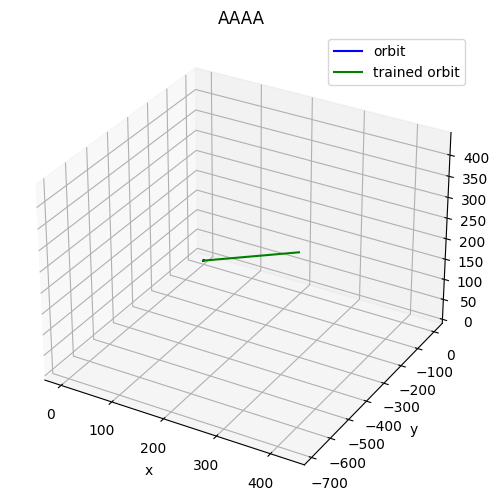

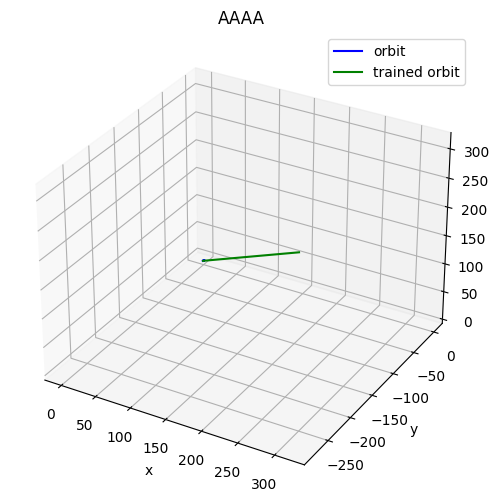

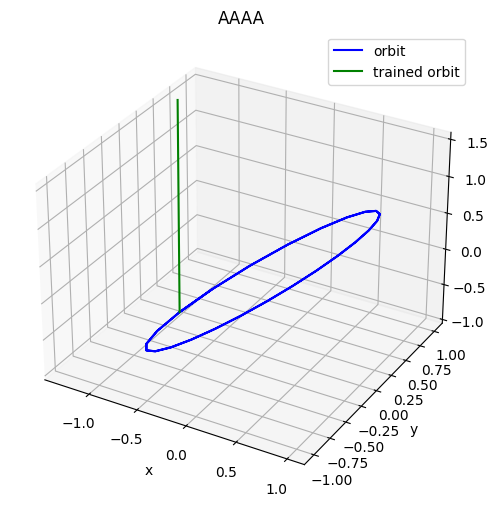

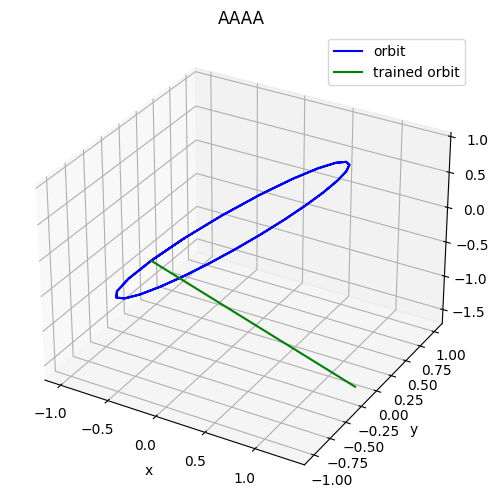

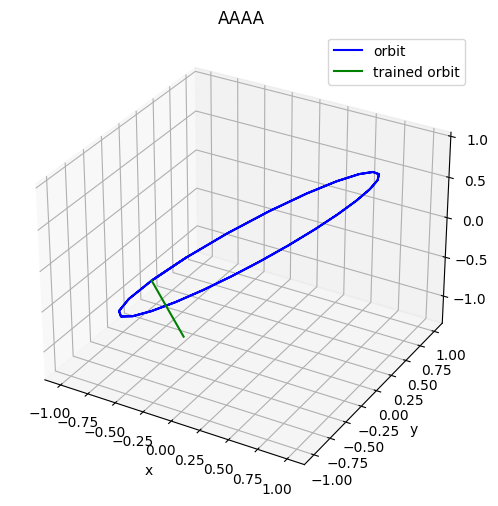

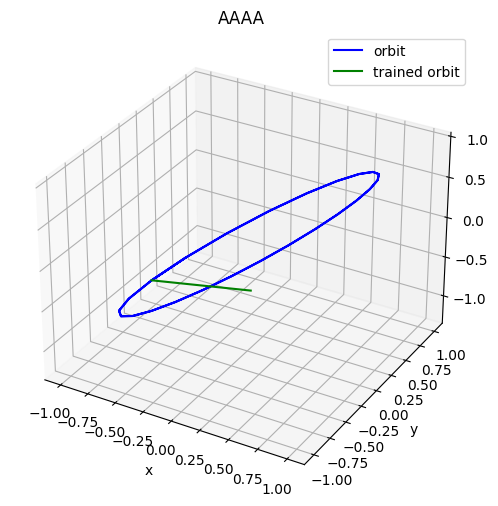

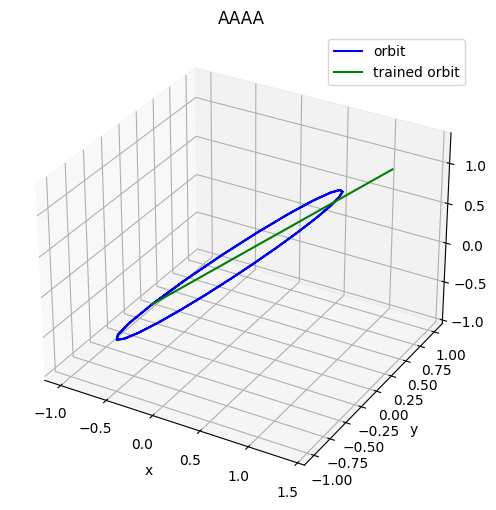

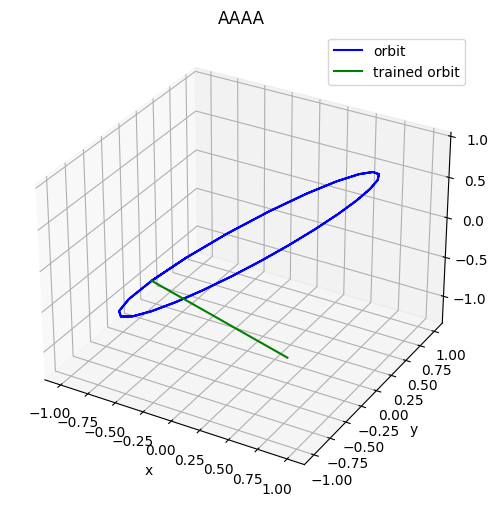

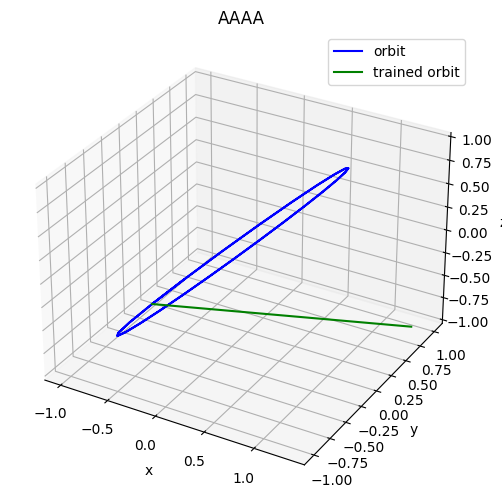

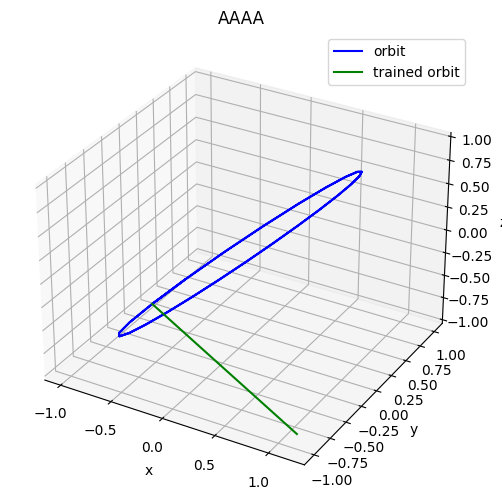

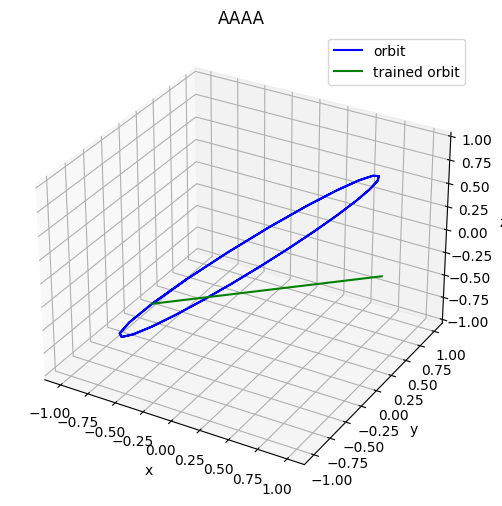

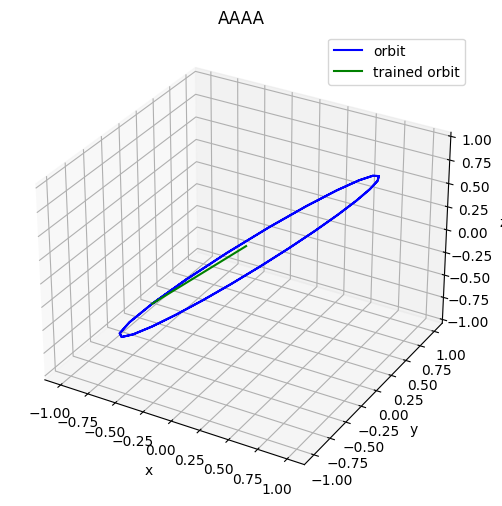

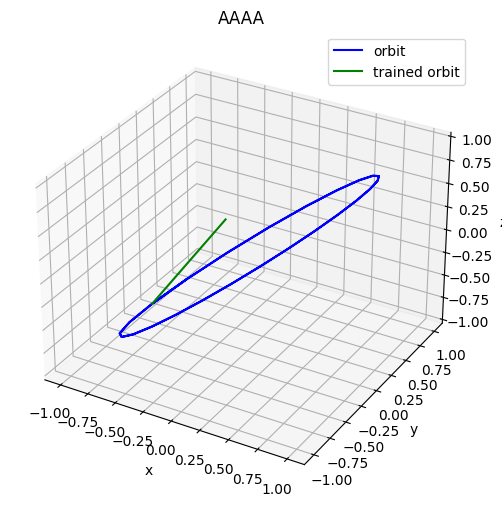

In [561]:

for i in range(len(y_pred_list)):
  fig = plt.figure(figsize=(12, 6))
  ax = plt.axes(projection="3d")

  y_pred = y_pred_list[i].detach().numpy()
  x, y, z = traj[:,0], traj[:,1], traj[:, 2]
  x_trained, y_trained, z_trained = y_pred[:,0], y_pred[:,1], y_pred[:,2]
  ax.plot3D(x, y, z, 'blue', label="orbit")
  ax.plot3D(x_trained, y_trained, z_trained, 'green', label="trained orbit")
  ax.legend()

  # Set labels and title
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.set_title("AAAA")

  plt.show()